# Automatic Number Plate Recognition System

# 1. Dependencies

**Note**: Newer Python versions require users to install dependencies in a virtual environment. Learn how to create a virtual environment [here](https://docs.python.org/3/library/venv.html), or if using Visual Studio Code, [here](https://code.visualstudio.com/docs/python/environments).

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install ultralytics scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.8/882.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import xml.etree.ElementTree as xet
import cv2
import re
import os
from glob import glob

from sklearn.model_selection import train_test_split
import shutil

from tqdm import tqdm

Make sure CUDA is available. CUDA is a program created by Nvidia that gives PyTorch direct access to the GPU, making processing way more efficient. CUDA cores (or devices) are computer cores that are specialised for parallel computing. If there aren't any CUDA cores available, it's probably because you're running the notebook on a CPU, not a GPU. Google Colab offers


In [ ]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# 2. Preprocessing

## 2.1 Define preprocessing

In [ ]:
# def preprocess_image(image):
#     # Apply edge detection
#     edges = cv2.Canny(image, 100, 200)

#     # Combine original image with edges
#     edge_enhanced = cv2.addWeighted(image, 0.8, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.2, 0)

#     return edge_enhanced

In [ ]:
def preprocess_image(image):

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Dynamic thresholding
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Define a kernel for morphological operations
    kernel = np.ones((3, 3), np.uint8)

    # Erosion followed by Dilation (Opening)
    # These operations can help enhance the shape of the characters on the license plate, connecting broken parts or removing small noise.
    # Ensure that the license plate characters are neither thinned out too much (as in erosion) nor over-expanded (as in dilation).
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    return opened_image



In [ ]:
def process_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all image files
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png'))]

    # Process each image
    for filename in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error reading image: {filename}")
            continue

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Save the processed image
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, processed_image)

## 2.2 Preprocess images in dataset

In [ ]:
from google.colab import drive

# Check if the directory exists and is empty
!ls /content/drive

# Remove existing files and directories (use with caution!)
!rm -rf /content/drive/*

# Mount Google Drive
drive.mount('/content/drive')

ls: cannot access '/content/drive': No such file or directory
Mounted at /content/drive


In [ ]:
input_directory = "/content/drive/MyDrive/Colab Notebooks/Image processing/dataset/images"
output_directory = "/content/drive/MyDrive/Colab Notebooks/Image processing/dataset/preprocessed_images"

process_dataset(input_directory, output_directory)

Processing images: 100%|██████████| 433/433 [00:27<00:00, 15.84it/s]


# 3. Data

## 3.1 Find data

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Image processing/dataset'

In [ ]:
def extract_number_from_str(filename):
    """Function to find a given image or label number to adjoin images and labels together."""
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [ ]:
# Store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [ ]:
# get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
assert xml_files, "Couldn't find dataset. Make sure to upload the dataset to Colab."

In [ ]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=extract_number_from_str):

    info = xet.parse(filename)
    root = info.getroot()

    # Extract bounding box coordinates
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'preprocessed_images', img_name)

    # add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)

alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/drive/MyDrive/Colab Notebooks/Image p...,226,419,125,173,500,268
1,/content/drive/MyDrive/Colab Notebooks/Image p...,134,262,128,160,400,248
2,/content/drive/MyDrive/Colab Notebooks/Image p...,229,270,176,193,400,400
3,/content/drive/MyDrive/Colab Notebooks/Image p...,142,261,128,157,400,225
4,/content/drive/MyDrive/Colab Notebooks/Image p...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/content/drive/MyDrive/Colab Notebooks/Image p...,142,258,128,157,400,225
429,/content/drive/MyDrive/Colab Notebooks/Image p...,86,208,166,195,301,400
430,/content/drive/MyDrive/Colab Notebooks/Image p...,38,116,159,197,400,225
431,/content/drive/MyDrive/Colab Notebooks/Image p...,55,343,82,147,400,192


## 3.2 Split data

In [ ]:
# Split dataset for training, testing and validation
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
Number of images in each set
Training:   {len(train)} images
Validation:  {len(val)} images
Testing:     {len(test)} images
''')


Number of images in each set
Training:   345 images
Validation:  44 images
Testing:     44 images



## 3.3 Convert data to YOLO format

In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    # folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plates', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plates', split_name, 'images')

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)
        os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plates/train/images' and 'datasets/cars_license_plates/train/labels'
Created 'datasets/cars_license_plates/val/images' and 'datasets/cars_license_plates/val/labels'
Created 'datasets/cars_license_plates/test/images' and 'datasets/cars_license_plates/test/labels'


# Object detection and bounding box

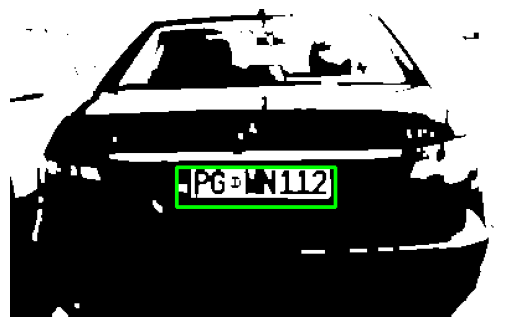

In [ ]:
image_dir = 'datasets/cars_license_plates/train/images'
label_dir = 'datasets/cars_license_plates/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
datasets_yaml = '''
path: cars_license_plates

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [ ]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 108MB/s]


In [ ]:
os.environ['WANDB_MODE'] = 'offline'

## train

In [ ]:
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True
)

Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 24.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.1MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/cars_license_plates/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 2025.59it/s]

train: New cache created: /content/datasets/cars_license_plates/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 753.93it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/cars_license_plates/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 1586.80it/s]

val: New cache created: /content/datasets/cars_license_plates/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 236.77it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.663G      2.015      3.669      1.482         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         44         44    0.00321      0.614      0.189     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.635G      1.875      2.663      1.248         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         44         44    0.00359       0.75     0.0244    0.00804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.644G      1.951      1.995      1.374         23        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         44         44    0.00277      0.432    0.00918    0.00349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.635G      1.895      1.902      1.414         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

                   all         44         44    0.00331      0.682    0.00444    0.00155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.635G      1.809      1.791      1.346         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


                   all         44         44      0.781       0.25      0.332       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.638G      1.809      1.673      1.331         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         44         44      0.575      0.295       0.33      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.635G      1.754      1.595      1.315         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         44         44      0.575      0.477      0.445      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.635G      1.803      1.551      1.297         19        320: 100%|██████████| 22/22 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


                   all         44         44      0.524      0.364      0.321      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.635G      1.764        1.5      1.324         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44      0.591      0.364      0.442      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.635G      1.768      1.504      1.283         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         44         44      0.651      0.614      0.658      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.635G      1.713      1.403      1.225         19        320: 100%|██████████| 22/22 [00:08<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         44         44      0.673      0.614      0.599      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.635G      1.718        1.4       1.26         21        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         44         44       0.61      0.606      0.559      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.635G      1.683      1.358      1.236         15        320: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         44         44      0.838      0.705      0.768      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.635G      1.706      1.318      1.252         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]

                   all         44         44      0.791      0.601      0.612      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.635G      1.704      1.293      1.227         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all         44         44      0.745      0.727      0.726      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.635G      1.637      1.267      1.215         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44      0.858      0.795      0.786      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.635G      1.531      1.187      1.157         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         44         44      0.728      0.773      0.705      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.635G      1.537      1.161      1.177         21        320: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         44         44      0.832      0.787      0.737      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.635G       1.52      1.141      1.147         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         44         44      0.771      0.688      0.738      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.635G      1.495      1.138      1.171         24        320: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]

                   all         44         44       0.97      0.742      0.822      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.635G      1.478      1.066      1.153         21        320: 100%|██████████| 22/22 [00:02<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         44         44      0.872      0.771      0.752       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.635G      1.546      1.144       1.17         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]

                   all         44         44      0.824      0.841      0.822       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.635G      1.505      1.132      1.173         14        320: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         44         44      0.963      0.596      0.768       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.635G       1.49        1.1      1.188         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]

                   all         44         44      0.715      0.614      0.596      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.635G      1.448      1.073      1.135         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

                   all         44         44      0.828      0.636      0.734      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.635G      1.483       1.08       1.15         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         44         44      0.833      0.773      0.792      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.635G      1.399     0.9819       1.11         18        320: 100%|██████████| 22/22 [00:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         44         44      0.861      0.702      0.818      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.635G       1.39     0.9675      1.103         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

                   all         44         44      0.869      0.753      0.803      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.635G      1.374     0.9832       1.13         23        320: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         44         44       0.85      0.841      0.826      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.635G      1.369     0.9542        1.1         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         44         44      0.883      0.818      0.884      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.635G      1.353     0.9395      1.099         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


                   all         44         44      0.872      0.818      0.849      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.635G      1.343     0.9503      1.087         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]

                   all         44         44      0.883      0.864       0.88      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.635G      1.445     0.9758      1.132         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]

                   all         44         44      0.921      0.793      0.786       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.635G      1.303     0.9154      1.092         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         44         44      0.915      0.818      0.859      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.635G      1.331     0.9061      1.091         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         44         44      0.943      0.841       0.88      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.635G      1.339     0.8999      1.081         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         44         44       0.97      0.726      0.817      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.635G      1.311     0.8889      1.085         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]

                   all         44         44      0.939      0.694      0.808      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.638G       1.36     0.9175      1.084         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         44         44       0.93      0.705      0.833      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.635G      1.296     0.8804      1.064         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         44         44      0.878      0.816      0.844      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.638G      1.293     0.8579      1.061         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         44         44      0.857      0.818      0.845      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.635G       1.25      0.874      1.067         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         44         44      0.857      0.817      0.878      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.638G      1.265     0.8404      1.082         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         44         44      0.859      0.841      0.863      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.635G      1.238     0.8204      1.059         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         44         44      0.888      0.841      0.888      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.635G      1.306     0.8331      1.052         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.76it/s]

                   all         44         44      0.829      0.886      0.882      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.635G      1.221      0.785      1.034         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]

                   all         44         44      0.818      0.841      0.863      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.635G      1.262     0.8464      1.059         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.974      0.845      0.894      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.635G       1.27     0.8213      1.051         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         44         44      0.894      0.818      0.867      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.635G      1.169     0.8046      1.019         13        320: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         44         44          1      0.814      0.854      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.635G      1.162     0.7549      1.028         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]

                   all         44         44      0.994      0.818      0.892      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.635G      1.184     0.7982      1.021         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

                   all         44         44      0.972      0.792      0.869      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.635G      1.165     0.8061      1.025         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44      0.932      0.705      0.829      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.635G      1.131     0.7773      1.029         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         44         44      0.971      0.762      0.865      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.635G       1.16     0.7537      1.012         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         44         44      0.922      0.773      0.872      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.635G      1.133     0.7587       1.02         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         44         44        0.9      0.864      0.882      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.635G      1.152       0.79      1.029         10        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]

                   all         44         44      0.948      0.828      0.887      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.635G      1.136     0.7445      1.014         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         44         44      0.938      0.795      0.868      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.635G      1.096     0.7453      1.004         14        320: 100%|██████████| 22/22 [00:03<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         44         44      0.926      0.818      0.878      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.635G      1.133     0.7615      1.009         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

                   all         44         44      0.943      0.773      0.856      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.635G      1.107     0.7223      1.004         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

                   all         44         44       0.97      0.742      0.873      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.635G      1.103     0.7271      1.014         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

                   all         44         44      0.947      0.813      0.862      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.635G      1.106     0.7216      1.001         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.917      0.818      0.902       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.635G      1.061      0.704       0.99         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44      0.975       0.75      0.883      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.635G      1.068     0.7065      1.003          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         44         44      0.971      0.772      0.865       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.638G      1.062     0.6979     0.9965         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

                   all         44         44      0.941      0.795       0.87      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.635G      1.096     0.7041     0.9965         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         44         44      0.953      0.795      0.848      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.635G      1.026     0.6756     0.9838         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

                   all         44         44      0.939      0.818      0.874      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.633G      1.052     0.6852      0.983         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         44         44      0.968      0.795      0.879      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.638G      1.058     0.6787     0.9669         21        320: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         44         44      0.961      0.795      0.881       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.635G     0.9795     0.6582     0.9701         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

                   all         44         44      0.986      0.773      0.873       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.635G     0.9818     0.6349     0.9733         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]

                   all         44         44      0.979      0.773      0.866      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.635G      1.011     0.6568     0.9661         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]

                   all         44         44      0.994      0.773      0.876      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.638G      1.006     0.6424     0.9694         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         44         44      0.959      0.841      0.878      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.635G      1.031     0.6722     0.9733         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

                   all         44         44      0.939      0.841      0.884      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.635G      1.052     0.6697      0.976         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         44         44       0.88      0.886      0.881      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.635G     0.9859     0.6435     0.9697         11        320: 100%|██████████| 22/22 [00:02<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

                   all         44         44      0.947      0.817      0.877       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.635G     0.9966     0.6371     0.9711         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         44         44      0.942      0.818      0.873      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.635G     0.9623      0.613     0.9516         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         44         44      0.913      0.818      0.873      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.635G     0.9812     0.6374     0.9574         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         44         44      0.989      0.773       0.87      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.635G      1.004     0.6417     0.9878         20        320: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]

                   all         44         44      0.979       0.75      0.879      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.638G     0.9672     0.6253     0.9648         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44      0.926      0.854      0.883      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.635G       0.95     0.6196     0.9479         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         44         44      0.906      0.886      0.891      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.635G     0.9688     0.5987     0.9517         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         44         44       0.95      0.862       0.89       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.635G     0.9179     0.5654     0.9388         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]

                   all         44         44      0.945      0.841      0.888      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.635G      0.901      0.589     0.9305         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]

                   all         44         44      0.945      0.841      0.892      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.635G     0.9466     0.5975      0.947         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


                   all         44         44       0.95      0.862      0.883      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.635G     0.9049     0.6012     0.9488         15        320: 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

                   all         44         44      0.942      0.841       0.88      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.635G     0.9475     0.6082     0.9439         22        320: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         44         44      0.919      0.841       0.88       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.635G     0.9137     0.5919     0.9489         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.926      0.859      0.887      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.635G     0.9391     0.5926     0.9517         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

                   all         44         44      0.924      0.824      0.883      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.635G     0.9209     0.5884     0.9537         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         44         44      0.944      0.841      0.878      0.505


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.635G      1.128      0.667      1.031          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         44         44      0.947      0.817      0.868      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.633G       1.13     0.6616       1.02          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

                   all         44         44      0.946      0.793      0.836      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.635G       1.13     0.6463      1.039          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]

                   all         44         44      0.946      0.792       0.85      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.635G      1.098     0.6305      1.034          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


                   all         44         44      0.947      0.812      0.876      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.635G      1.084     0.6282      1.019          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         44         44      0.934      0.818      0.882      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.633G      1.075     0.6347      1.018          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

                   all         44         44      0.944      0.818      0.883      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.635G      1.053     0.6129      1.006          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         44         44       0.94      0.818      0.881      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.635G      1.053     0.6126      1.013          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


                   all         44         44      0.938      0.818       0.88      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.635G      1.017     0.6103     0.9896          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         44         44      0.938      0.818      0.881      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.635G      1.046     0.6088      1.004          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         44         44      0.938      0.818      0.885      0.486



100 epochs completed in 0.124 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


                   all         44         44      0.924      0.824      0.883       0.51
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d584a9e4a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

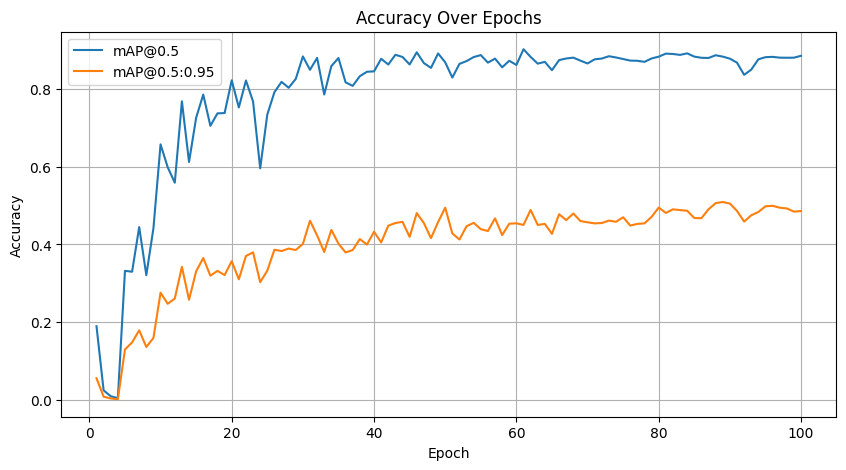

In [ ]:
# Find recent training log dir 0.
log_dir = max(glob('runs/detect/train*'), key=extract_number_from_str)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# save model
model.save('anpr-v1.pt')

# Test and predictions

In [ ]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /content/drive/MyDrive/Colab Notebooks/Image processing/dataset/preprocessed_images/Cars425.png: 160x320 1 license_plate, 34.0ms
Speed: 1.2ms preprocess, 34.0ms inference, 14.0ms postprocess per image at shape (1, 3, 160, 320)


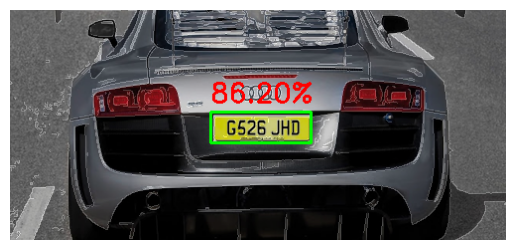

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /content/drive/MyDrive/Colab Notebooks/Image processing/dataset/preprocessed_images/Cars181.png: 320x192 1 license_plate, 57.5ms
Speed: 1.1ms preprocess, 57.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)


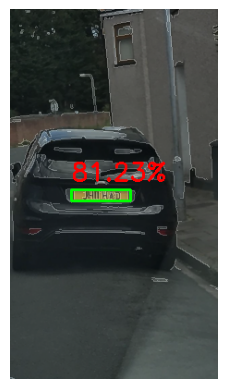

In [ ]:
predict_and_plot(test.iloc[2].img_path)